In [337]:
import random
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from deap import base, creator, tools, algorithms

In [338]:
random.seed(123)

## Evolution function

In [339]:
def evolution(
    individual_template,
    population_size,
    fitness_function,
    maximize,
    selection_function,
    crossover_function,
    mutation_function,
    P_mutation,
    P_crossover,
    number_of_iterations
    ):
    
    # generating the population from the templates
    population = [individual_template() for i in range(population_size)]
    
    # fitness array - index = index of the individual
    fitness = [fitness_function(i) for i in population]

    # iterating the generations
    for _ in range(number_of_iterations):
        new_generation = []
        # filling the new generation with altered individuals from the previous generation
        while len(new_generation) < len(population):
            p = random.random()
            q = random.random()

            # Selection
            new_individual_1 = selection_function(population, fitness_function, maximize)
            new_individual_2 = selection_function(population, fitness_function, maximize)

            # Crossover
            if p < P_crossover:
                new_individual_1, new_individual_2 = crossover_function(new_individual_1, new_individual_2)

            # Mutation
            if q < P_mutation:
                new_individual_1 = mutation_function(new_individual_1)
                new_individual_2 = mutation_function(new_individual_2)
                
            new_generation.append(new_individual_1)
            if len(new_generation) == len(population):
                break
            new_generation.append(new_individual_2)

        # calculate the new fitness
        fitness = [fitness_function(i)[0] for i in new_generation]
    

        # outputting information about current generation
        if ((_  + 1) % 100 == 0):
            print(f"{_ + 1}. generation |\
        mean = {sum(fitness) / len(fitness)} |\
        {'max' if maximize else 'min'} = {max(fitness) if maximize else min(fitness)}")

        # switch old generation with the new generation
        population = new_generation
    return population
        


## Functions generating different individuals for the population

Purpose of these functions is to simply generate individuals for given evolution algorithm. Closures returning the function with given parameters. An individual is expected to be an array of elements - all individual arrays have the same length.

In [340]:
# binary array of length n
def binary_individual(bit_num):
    def binary_individual_func():
        return [random.randint(0, 1) for _ in range(bit_num)]
    return binary_individual_func

# integer array from a to b of length n
def integer_individual(n, a, b):
    def integer_individual_func():
        return [random.randint(a, b) for _ in range(n)]
    return integer_individual_func    

# float array from a to b of length n
def float_individual(float_num, a=0, b=1):
    def float_individual_func():
        return [random.random() * (b - a) + a for _ in range(float_num)]
    return float_individual_func

## Simple fitness functions

Fitness function expects an individual on input (an array of elements). It returns a single numerical value.

In [341]:
# sum of all properties
def fitness_sum(arr):
    return sum(arr)

# standard deviation
def fitness_sigma(arr):
    return statistics.stdev(arr)

### Fitness functions for terrain evaluation

creating a terrain with three lakes and without extreme points (high or low)

In [342]:
def three_lake_not_extreme_terrain(arr):
    lakes = 0
    prev_underwater = None
    underwater = False
    prev = arr[0]
    extreme_penalty = 0
    for point in arr:
        prev_underwater = underwater
        underwater = True if point < 0.5 else False
        if underwater and not prev_underwater:
            lakes += 1
        extreme_penalty += abs(0.5 - point) * 2
    return (abs(3 - lakes) + extreme_penalty,)
        

creating a deep lake in the middle which is surrounded by mountains
the shape is simmilar to a function 0.4*sin(x/2 - 30.5) + 0.5 on interval 0-15 

In [343]:
def deep_lake_surrounded_by_mountains(arr):
    difference = 0
    for x_coord in range(15):
        sin_value = 0.4 * math.sin((x_coord / 2) - 30.5) + 0.5
        difference += (sin_value - arr[x_coord]) ** 2
    return (difference,)
    

## Simple selection functions

In [344]:
def tournament(batch_size):
    def tournament_func(population, fitness_function, maximize):
        arena = random.sample(population, batch_size)
        if random.random() < 0.5:
            return random.choice(arena)
        return max(arena, key=fitness_function) if maximize else min(arena, key=fitness_function)
    return tournament_func



## Crossover function

In [345]:
def one_point_crossover(individual_1, individual_2):
    index = random.randint(0, len(individual_1) - 1)
    mutant_1 = individual_1[0:index] + individual_2[index:]
    mutant_2 = individual_2[0:index] + individual_1[index:]
    return mutant_1, mutant_2

## Mutation function

Takes in two arguments - whole population and a probability of one value mutation. It also specifies, how the value will be altered.

In [346]:
def bit_mutation(mutant, mutation_part):
    number_of_mutations = round(len(mutant) * mutation_part)
    mutation_indexes = random.sample(range(len(mutant), number_of_mutations))
    helper_dict = {0:1, 1:0}
    mutant = [helper_dict[i] if i in mutation_indexes else i for i in mutant ]
    return mutant

def float_mutation(a, b, mutation_part):
    def float_mutation_func(mutant):
        number_of_mutations = round(len(mutant) * mutation_part)
        mutation_indexes = random.sample(range(len(mutant)), number_of_mutations)
        mutant = [mutant[i] if i not in mutation_indexes else (random.random() * (b - a) + a) for i in range(len(mutant)) ]
        return mutant
    return float_mutation_func
    

## Terrain visualisation

In [347]:
def display_terrain(arr):    
    # array of x values => x-axis
    x = np.arange(0, len(arr))
    
    # Function y=0.5 => water level
    y_half = np.full(len(arr), 0.5)    

    # filling water level
    plt.fill_between(x, y_half, 0, color='blue')

    # filling the surface
    plt.fill_between(x, arr, 0, color='orange')
    
    # plotting the line for values from array
    plt.plot(x, arr, color='black')
    
    # Set the y-axis limits to ensure the horizontal line is visible
    plt.ylim(0, 1)
    
    # Add title
    plt.title('Terrain')
    
    # Show the plot
    plt.show()

# Evolution call
using custom evolution algorithm and deep lake surrounded by mountains fitness function

In [348]:
individual_template = float_individual(float_num=15)
population_size = 20
fitness_function =  deep_lake_surrounded_by_mountains
maximize = False
selection_function = tournament(batch_size=3)
crossover_function = one_point_crossover
mutation_function = float_mutation(0, 1, 0.3)
P_mutation = 0.2
P_crossover = 0.6
number_of_iterations = 1000



x = evolution(
    individual_template,
    population_size,
    fitness_function,
    maximize,
    selection_function,
    crossover_function,
    mutation_function,
    P_mutation,
    P_crossover,
    number_of_iterations
    )

100. generation |        mean = 0.2165586600543714 |        min = 0.13625784908110813
200. generation |        mean = 0.24891057787354692 |        min = 0.03872348745112527
300. generation |        mean = 0.24772095044155473 |        min = 0.030591791675801106
400. generation |        mean = 0.36636081811193955 |        min = 0.01933448887871417
500. generation |        mean = 0.5744082417005542 |        min = 0.020442804335323184
600. generation |        mean = 0.3330496679047005 |        min = 0.03588471238994966
700. generation |        mean = 0.21028982872566707 |        min = 0.024465548986538996
800. generation |        mean = 0.25078862251559375 |        min = 0.014417974330470531
900. generation |        mean = 0.09815465753124315 |        min = 0.012878049887594454
1000. generation |        mean = 0.1955710020589307 |        min = 0.012878049887594454


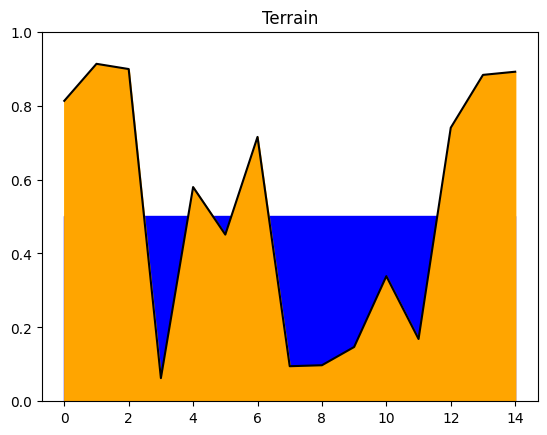

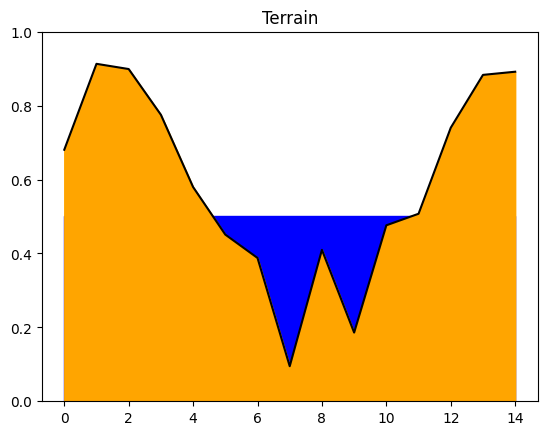

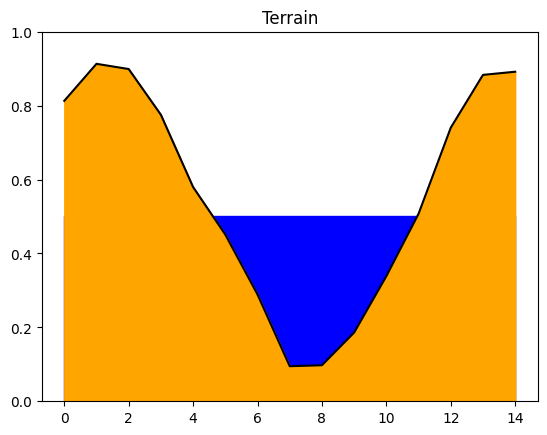

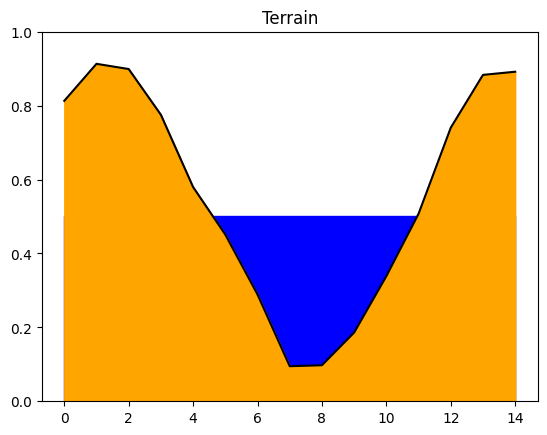

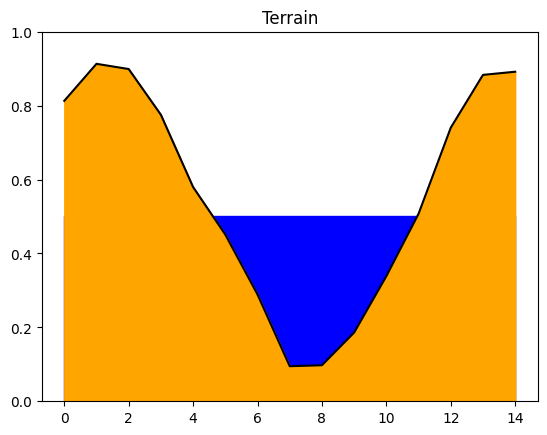

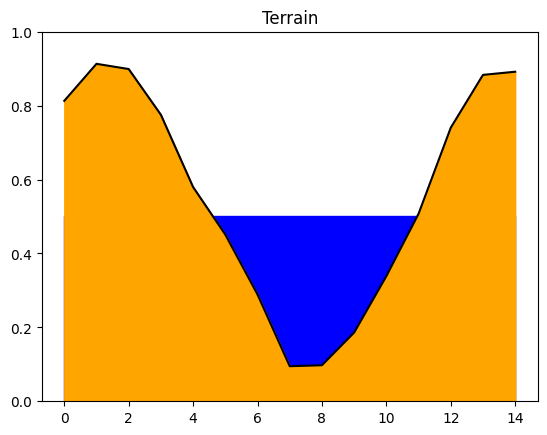

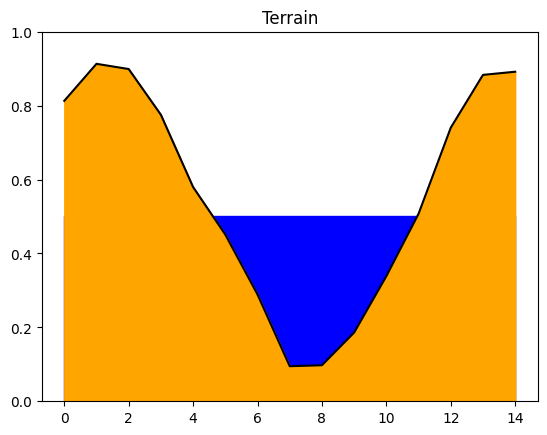

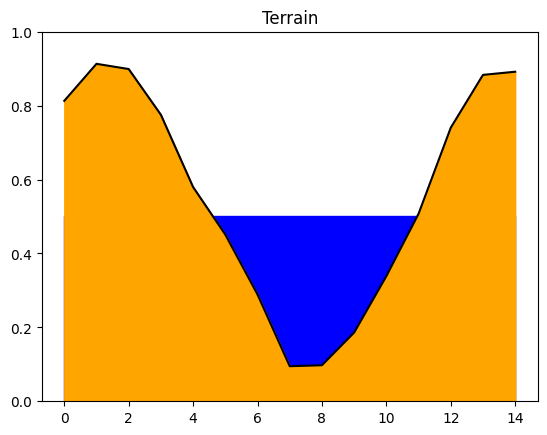

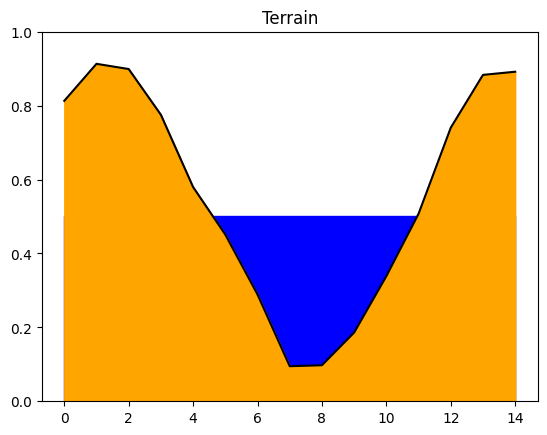

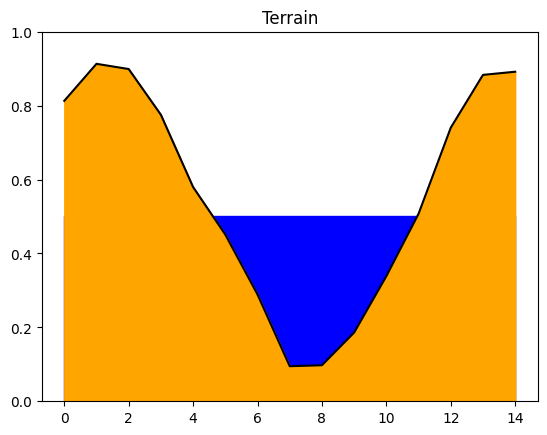

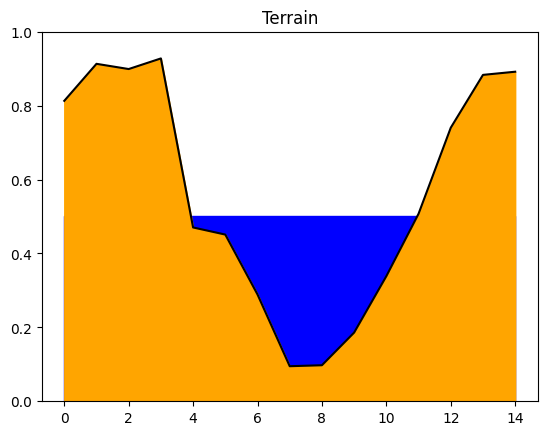

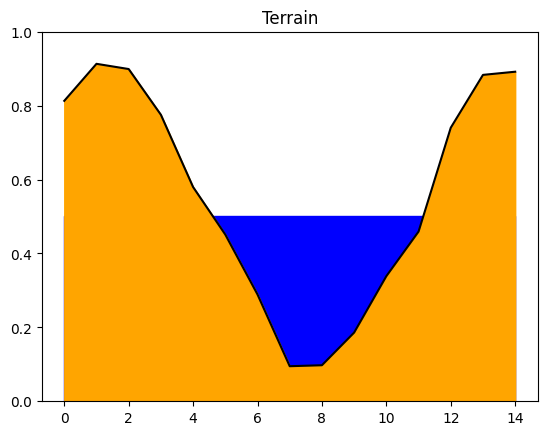

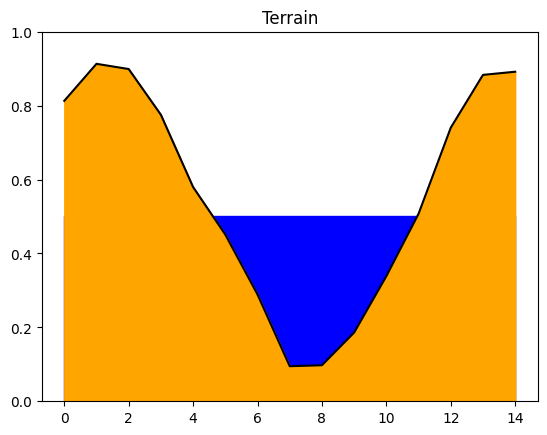

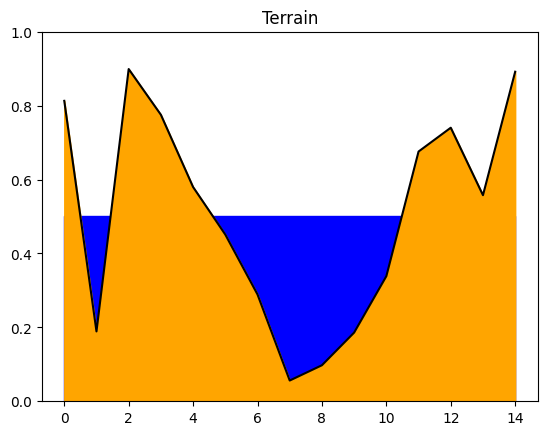

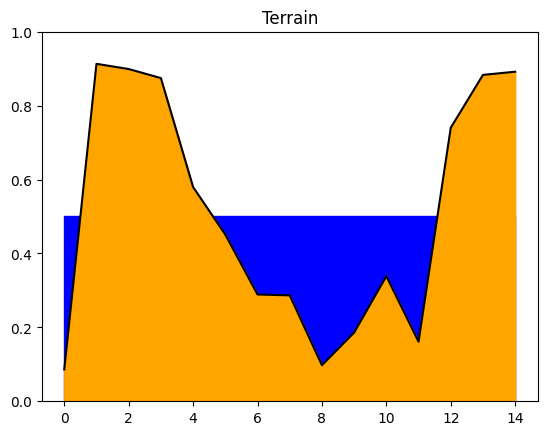

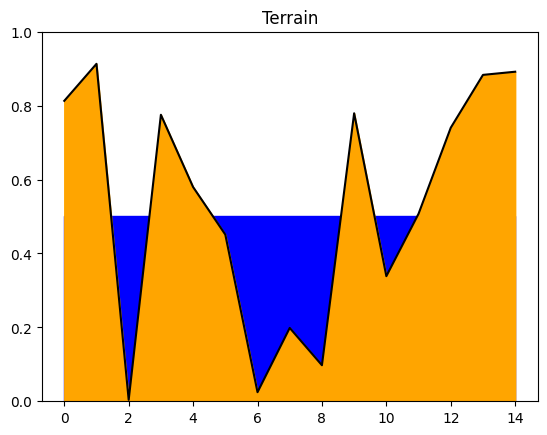

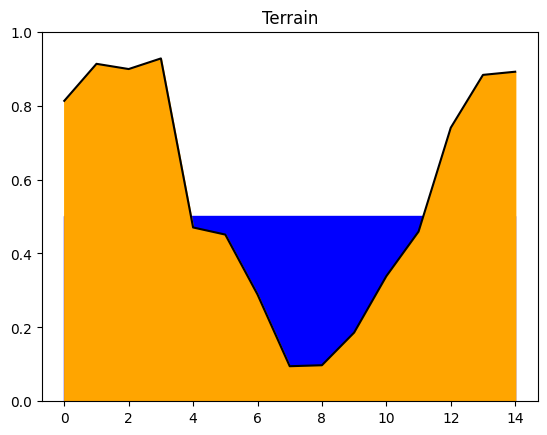

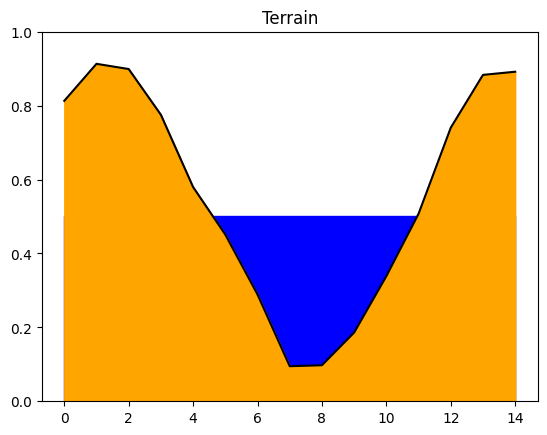

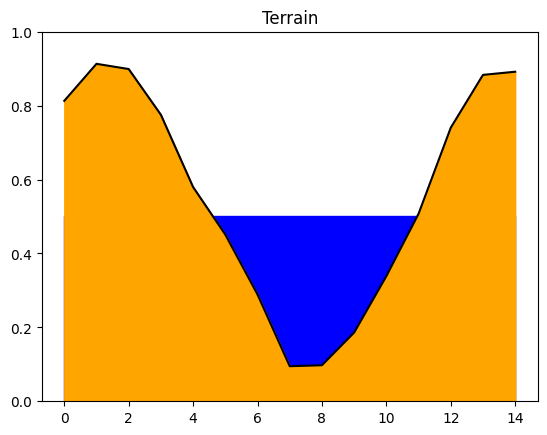

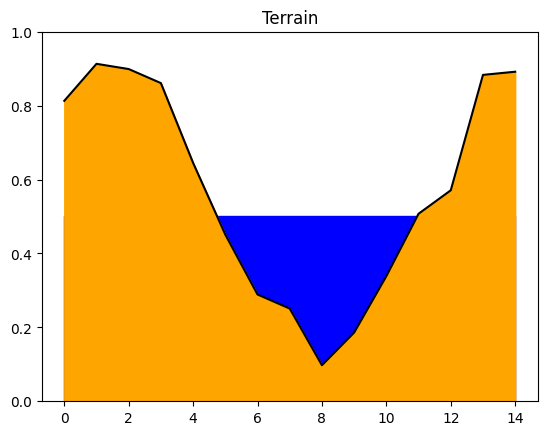

In [349]:
for i in x:
    display_terrain(i)

## Evolution Call
using DEAP library and three lakes + not extreme fitness function

In [350]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=15)
toolbox.register("population", tools.initRepeat, list, toolbox.individual) 

toolbox.register("evaluate", three_lake_not_extreme_terrain)

toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=10)
NGEN = 50
CXPB = 0.7           
MUTPB = 0.2       

finalpopulation, logbook = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN)

gen	nevals
0  	10    
1  	8     
2  	10    
3  	8     
4  	8     
5  	8     
6  	7     
7  	6     
8  	9     
9  	7     
10 	8     
11 	7     
12 	10    
13 	8     
14 	8     
15 	8     
16 	6     
17 	7     
18 	10    
19 	5     
20 	9     
21 	9     
22 	8     
23 	5     
24 	10    
25 	7     
26 	6     
27 	4     
28 	6     
29 	9     
30 	9     
31 	7     
32 	8     
33 	9     
34 	8     
35 	10    
36 	8     
37 	9     
38 	8     
39 	8     
40 	5     
41 	8     
42 	8     
43 	8     
44 	8     
45 	10    
46 	6     
47 	8     
48 	8     
49 	3     
50 	8     


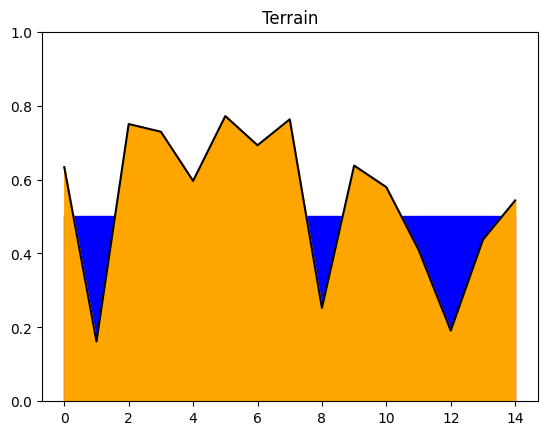

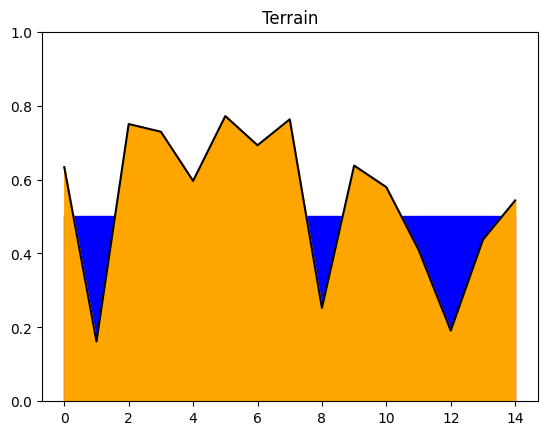

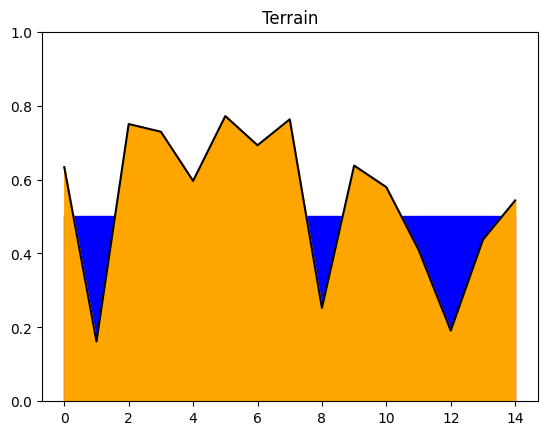

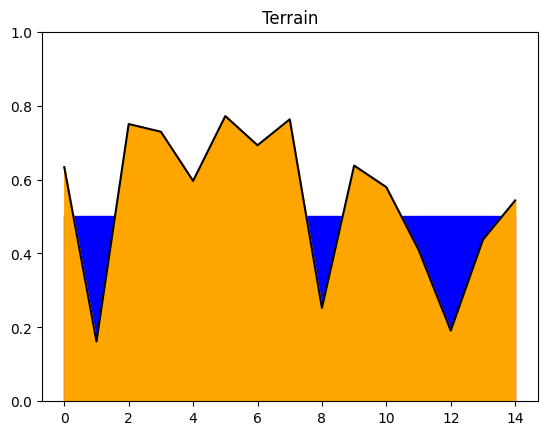

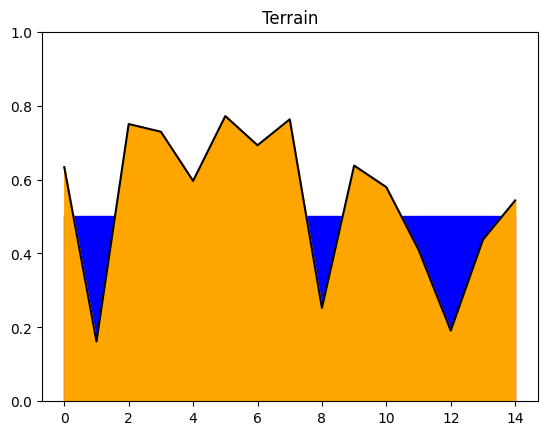

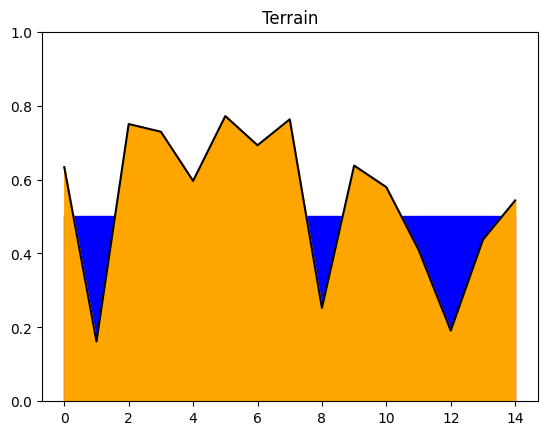

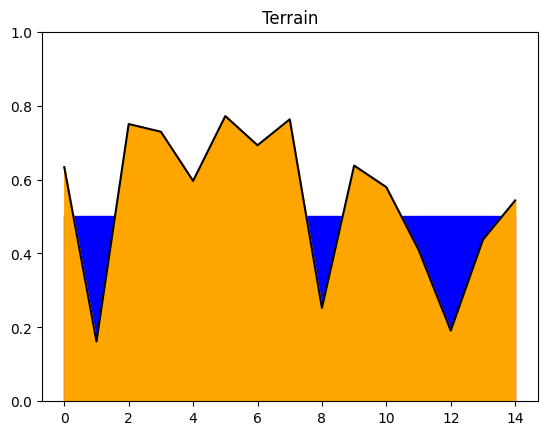

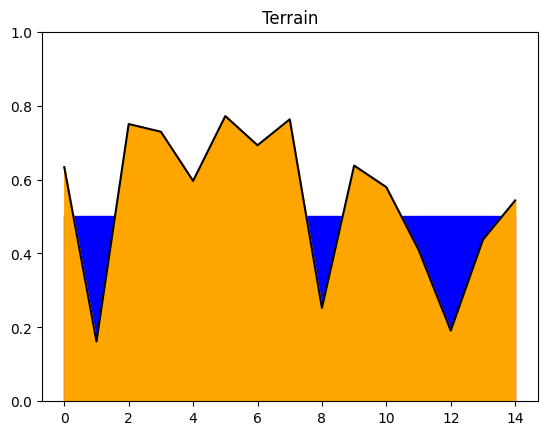

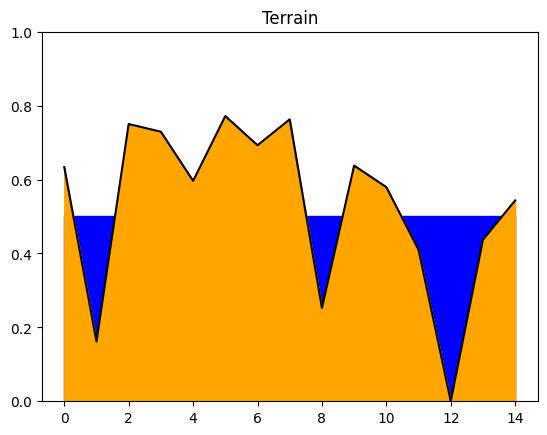

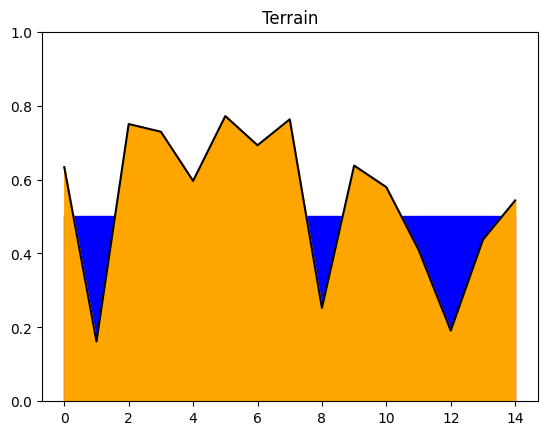

In [351]:
for i in finalpopulation:
    display_terrain(i)